# 简介
---------------------
在[上一篇博文](www.wyblog.cn/2016/11/05/天池初体验-新人实战赛之离线赛/)里，我用spark-sql工具简单的描述了如何操作这个比赛。

但是，存在一个很大的缺陷，就是数据的清晰度不够，我并不能直观的看到数据的分布特征是如何的，在这种状态下去构建特征，完全就是抓瞎，可能构建出的一些比较好的特征也会因为一些区分度不太明显的特征给扰乱，导致预测的不准确。基于以上原因，有必要对数据进行各种维度上的基础统计操作，并且以可视化的方式给展示出来，以便提供给我们是否将其作为特征向量或者如何构造特征向量作为决策依据。

我使用的工具是
- [Pandas](http://pandas.pydata.org/pandas-docs/stable/)
- [Seaborn](http://seaborn.pydata.org/)

用Pandas基于DataFrame去处理数据的确比用SQL方便很多，spark里也接入了DataFrame模型，但是API提供得不够丰富，很多操作存在限制，然而spark在大规模计算上存在无可比拟的优势。Seaborn提供了很多酷炫的数据可视化模型图，要玩转它，还需要不断学习关于统计学的基本知识，我这里学艺还不精，大多数都用的直方图来可视化，比较单一，以后慢慢学习使用其他的。总的来说，在我看来，理想情况是，用pandas及seaborn进行ETL，然后用spark-mlib进行机器学习模型训练。

阿里移动推荐赛提供的数据仅给出了用户对某个类别里的商品在某个时间点的交互模型，给出的地理位置标签缺失项太多，所以地理位置并不能起多大的作用。基于此，去分析数据大概只能够在时间这一个维度上去花功夫了。另一方面，数据集给出了user_id，item_id，item_category，所以对于特征，可以从这三个方面上基于时间对其分析。根据以下的可视化结果来看，有时候我们自己臆想出的一些特征，其实并没有很好的区分出用户的特点，相反，可能会更加模糊化。

另外，基于时间来分析的时候，有时是统计的一段时间内的行为数总量，有时统计的是某个时间点是否有某个行为，前后两者特征的值在数量级上相差其实比较大，如果贸然的将这两种特征放在一起进行训练，是否能达到理想效果值得商榷。

本篇文章仅记录下我尝试的数据分析的过程，作为新手，过程中难免出现纰漏，希望大家能不吝赐教，大家共同进步。

### 1.首先整理数据

In [2]:
#导入模块
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
rs = np.random.RandomState(10)

#读入user交互数据
user_df=pd.read_csv('train_user.csv')

#定义的函数用于处理时间，将日期与小时分开
def get_date(time):
    date,hour=time.split(" ")
    return date
def get_hour(time):
    date,hour=time.split(" ")
    return hour
user_df['date'] = user_df['time'].map(get_date)
user_df['date'] = pd.to_datetime(user_df['date'])
user_df['hour'] = user_df['time'].map(get_hour)
user_df['hour'] = user_df['hour'].astype(int)
behavior_type_dummies=pd.get_dummies(user_df['behavior_type'])
behavior_type_dummies.columns=['view','favor','addcar','buy']
user_df.drop(['behavior_type','time','user_geohash'],axis=1,inplace=True)
user_df=user_df.join(behavior_type_dummies)
user_df.head()

,user_id,item_id,item_category,date,hour,view,favor,addcar,buy
0,10001082,285259775,4076,2014-12-08,18,1,0,0,0
1,10001082,4368907,5503,2014-12-12,12,1,0,0,0
2,10001082,4368907,5503,2014-12-12,12,1,0,0,0
3,10001082,53616768,9762,2014-12-02,15,1,0,0,0
4,10001082,151466952,5232,2014-12-12,11,1,0,0,0


- Pandas的get_dummies()函数是一个非常厉害的函数，它能对clomns进行[独热编码](http://www.wyblog.cn/2016/10/31/%e6%95%b0%e6%8d%ae%e9%a2%84%e5%a4%84%e7%90%86-one-hot%e7%bc%96%e7%a0%81/)。以上我对behavior_type进行独热编码，可以展示出用户对商品在时间点上的具体操作类型，方便以后进行更加详细的统计。

----------------------

### 2.用户商品对分析

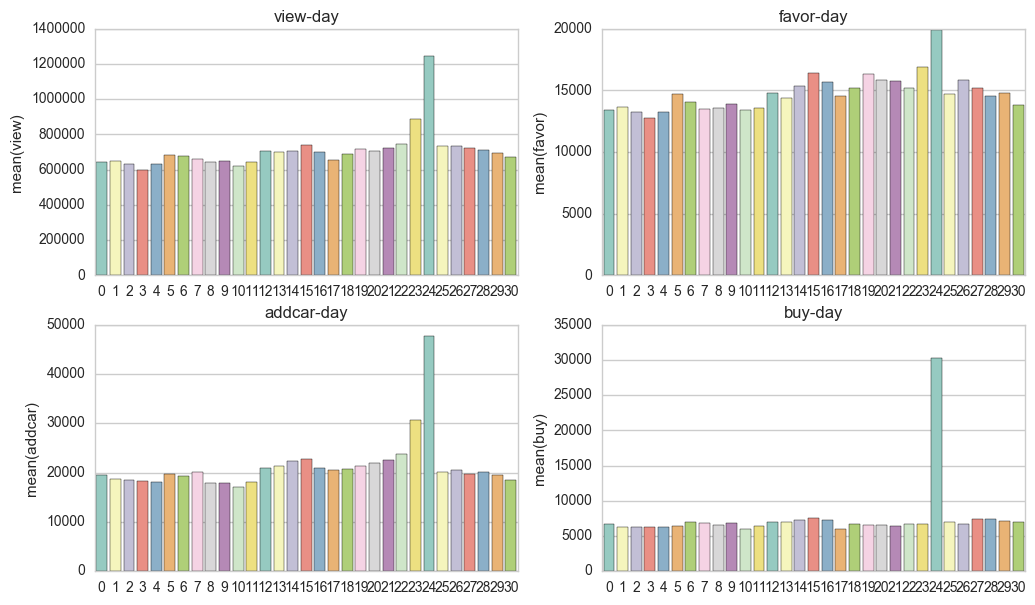

In [2]:
#绘制这个月内每一天所有互动类型的总量
month_total=user_df[['view','favor','addcar','buy','date']].groupby('date',as_index=False).sum()
f,axes=plt.subplots(2,2,figsize=(12,7))
axes[0,0].set_title("view-day")
axes[0,1].set_title("favor-day")
axes[1,0].set_title("addcar-day")
axes[1,1].set_title("buy-day")
sns.barplot(month_total.index, month_total.view,palette="Set3",ax=axes[0,0])
sns.barplot(month_total.index, month_total.favor,palette="Set3",ax=axes[0,1])
sns.barplot(month_total.index, month_total.addcar,palette="Set3",ax=axes[1,0])
sns.barplot(month_total.index, month_total.buy,palette="Set3",ax=axes[1,1])

在以上统计图里，有几个比较有意思的现象。
1. 首先比较明显的看到，在第24天(也就是双十二)，数据有明显的波动。在双十二前一天，浏览、收藏以及加购行为相对于平时，都有一定的提升，但是购买行为，仅仅在双十二当天才有异常，其余日期上都比较稳定。这在如何处理双十二及双十二前后一天的数据上需要仔细考虑。
2. 在这一个月时间内，数据似乎存在一个小周期，一个星期内，各种行为量先下降后上升。
3. 从第四幅购买量的图来看，似乎双十二仅仅影响了当天，在12号过后，每天的购买量又回到了平日的水平，个人觉得这是阿里对数据进行了特殊处理才造成这个现象，双十二的购买量达到了平日的六倍左右，基于此，直接剔除掉双十二的购买数据应该比较好。

----------------------

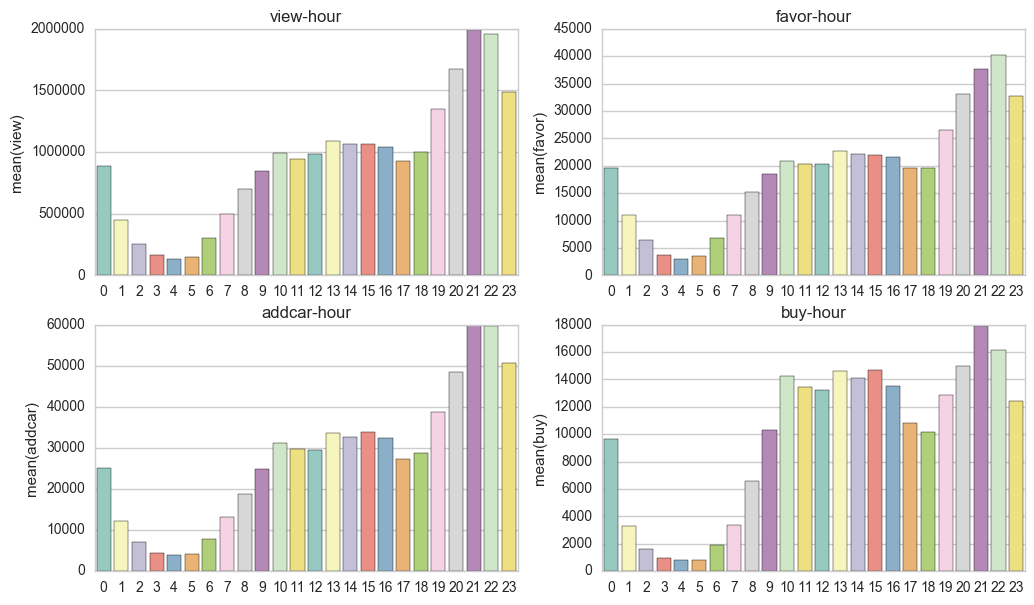

In [3]:
#绘制这个月内按小时时段统计的互动类型总量
day_detail=user_df[['view','favor','addcar','buy','hour']].groupby('hour',as_index=False).sum()
f,axes=plt.subplots(2,2,figsize=(12,7))
axes[0,0].set_title("view-hour")
axes[0,1].set_title("favor-hour")
axes[1,0].set_title("addcar-hour")
axes[1,1].set_title("buy-hour")
sns.barplot(day_detail.index, day_detail.view,palette="Set3",ax=axes[0,0])
sns.barplot(day_detail.index, day_detail.favor,palette="Set3",ax=axes[0,1])
sns.barplot(day_detail.index, day_detail.addcar,palette="Set3",ax=axes[1,0])
sns.barplot(day_detail.index, day_detail.buy,palette="Set3",ax=axes[1,1])

- 从24小时这个维度来看，单独把交互行为的时间点给提取出来还是很有意义的，在各个时间点进行交互最后被购买的概率相差还是挺大。
- 同时，可以看到，对于浏览、点击、加购物车的交互次数在晚上明显高于白天时间，然而在购买量上边，晚上与白天却相差的不是想象的那么大，是否能够说明白天的交互的转化率要高于晚上？也就是白天交互被购买的概率要更加大一些。

------------------------------------

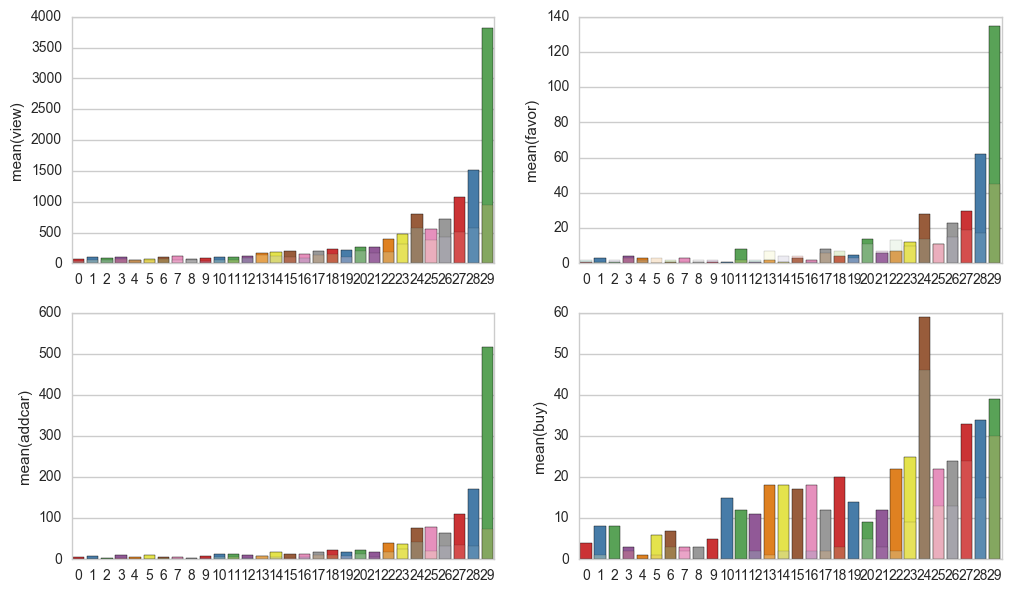

In [4]:
month_detail=user_df[['user_id','item_id','date','view','favor','addcar','buy']].groupby(['user_id','item_id','date'],as_index=False).sum()
day18_positive=month_detail[['user_id','item_id']][(month_detail.date=='2014-12-18')&(month_detail.buy!=0)]
day18_negative=month_detail[['user_id','item_id']][(month_detail.date=='2014-12-18')&(month_detail.buy==0)].sample(n=6124)

day18_buy_1month_detail=day18_positive.merge(month_detail,how='left',on=['user_id','item_id'],).groupby('date',as_index=False).sum()
day18_notbuy_1month_detail=day18_negative.merge(month_detail,how='left',on=['user_id','item_id'],).groupby('date',as_index=False).sum()
#去除18号的数据
day18_buy_1month_detail=day18_buy_1month_detail.drop(30)
day18_notbuy_1month_detail=day18_notbuy_1month_detail.drop(30)

f,axes=plt.subplots(2,2,figsize=(12,7))
sns.barplot(day18_buy_1month_detail.index, day18_buy_1month_detail.view,palette="Set1",ax=axes[0,0])
sns.barplot(day18_notbuy_1month_detail.index, day18_notbuy_1month_detail.view,palette="Set3",ax=axes[0,0],alpha=.3)
sns.barplot(day18_buy_1month_detail.index, day18_buy_1month_detail.favor,palette="Set1",ax=axes[0,1])
sns.barplot(day18_notbuy_1month_detail.index, day18_notbuy_1month_detail.favor,palette="Set3",ax=axes[0,1],alpha=.3)
sns.barplot(day18_buy_1month_detail.index, day18_buy_1month_detail.addcar,palette="Set1",ax=axes[1,0])
sns.barplot(day18_notbuy_1month_detail.index, day18_notbuy_1month_detail.addcar,palette="Set3",ax=axes[1,0],alpha=.3)
sns.barplot(day18_buy_1month_detail.index, day18_buy_1month_detail.buy,palette="Set1",ax=axes[1,1])
sns.barplot(day18_notbuy_1month_detail.index, day18_notbuy_1month_detail.buy,palette="Set3",ax=axes[1,1],alpha=.3)

- 以上的代码中，我提取出了十八号当天购买了及未购买的 (用户,商品) 对，未购买的是通过随机抽取出相同数量的对，并把每一种交互行为都绘制于同一个统计图里。
- 可以看到，在18号被购买的商品，在前一个星期内的交互行为都是逐渐上升的趋势，越距离购买日近，交互的越多，这与我们直观印象是相符的。对于收藏行为，区分度没有浏览与加购行为高，因为18号未购买的那些用户的收藏行为数量有好几天都比18号购买了的用户收藏数量更高（透明条形图更高些）。
- 对于购买行为，更有意思一些，它图像的坡度没有那么抖，而且在具体18号半个月之前的每天，曾被购买的数量都差不多，而且相对于未被购买的数据，相差也很大。总的来说，对于浏览、收藏、加购行为，我们基本可以只统计最近一周的数量就行了，而重复购买行为，最好统计整个月比较好。

-------------------------------

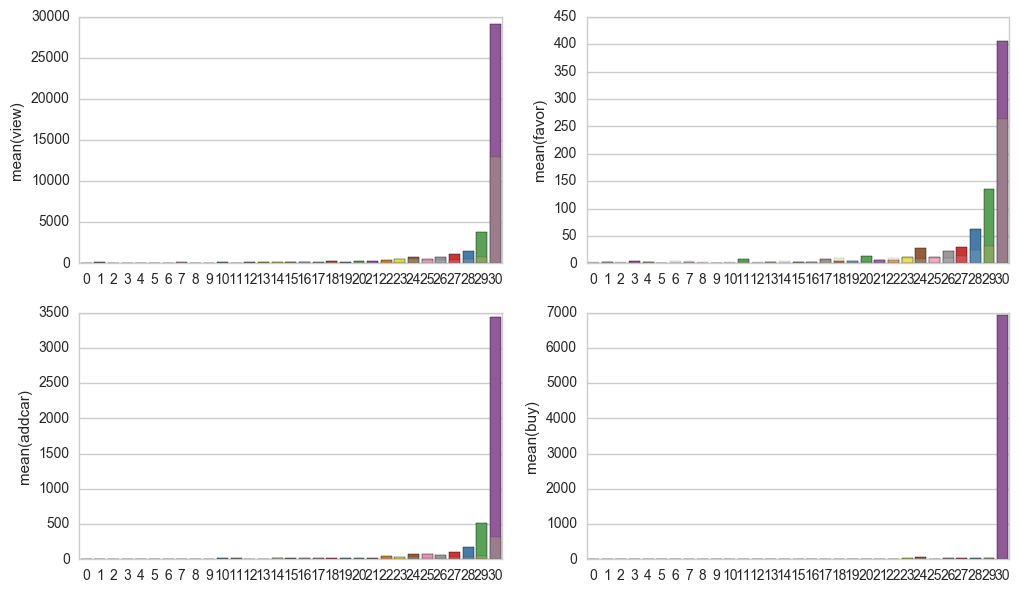

In [5]:
#作为对比，可以看看不去除12月18号的数据的情况
month_detail=user_df[['user_id','item_id','date','view','favor','addcar','buy']].groupby(['user_id','item_id','date'],as_index=False).sum()
day18_positive=month_detail[['user_id','item_id']][(month_detail.date=='2014-12-18')&(month_detail.buy!=0)]
day18_negative=month_detail[['user_id','item_id']][(month_detail.date=='2014-12-18')&(month_detail.buy==0)].sample(n=6124)

day18_buy_1month_detail=day18_positive.merge(month_detail,how='left',on=['user_id','item_id'],).groupby('date',as_index=False).sum()
day18_notbuy_1month_detail=day18_negative.merge(month_detail,how='left',on=['user_id','item_id'],).groupby('date',as_index=False).sum()

f,axes=plt.subplots(2,2,figsize=(12,7))
sns.barplot(day18_buy_1month_detail.index, day18_buy_1month_detail.view,palette="Set1",ax=axes[0,0])
sns.barplot(day18_notbuy_1month_detail.index, day18_notbuy_1month_detail.view,palette="Set3",ax=axes[0,0],alpha=.3)
sns.barplot(day18_buy_1month_detail.index, day18_buy_1month_detail.favor,palette="Set1",ax=axes[0,1])
sns.barplot(day18_notbuy_1month_detail.index, day18_notbuy_1month_detail.favor,palette="Set3",ax=axes[0,1],alpha=.3)
sns.barplot(day18_buy_1month_detail.index, day18_buy_1month_detail.addcar,palette="Set1",ax=axes[1,0])
sns.barplot(day18_notbuy_1month_detail.index, day18_notbuy_1month_detail.addcar,palette="Set3",ax=axes[1,0],alpha=.3)
sns.barplot(day18_buy_1month_detail.index, day18_buy_1month_detail.buy,palette="Set1",ax=axes[1,1])
sns.barplot(day18_notbuy_1month_detail.index, day18_notbuy_1month_detail.buy,palette="Set3",ax=axes[1,1],alpha=.3)

- 当我把18号当天的数据保留时，很明显，居然大部分交互数据都发生在购买当天。也就是说，绝大部分被购买的商品都是当天交互，当天被购买。对于这部分数据，我们其实是没法进行预测的，我们根本就拿不到19号的交互数据。
- 另外，通过购买图也能发现一个问题，18号当天被购买的商品，只有很少出现前一天、前两天、甚至前一周内曾被购买。而我自己通过曾经的得分，倒推过服务器那边的正确答案数量，达到500到600条左右。通过这两点分析，如果我们只使用某一两天的交互数据作为正样本来进行训练，包含的可能被购买的数量就太少了，至少得抽出一周的数据作为正样本，再训练，才比较合理。

---------------------------------

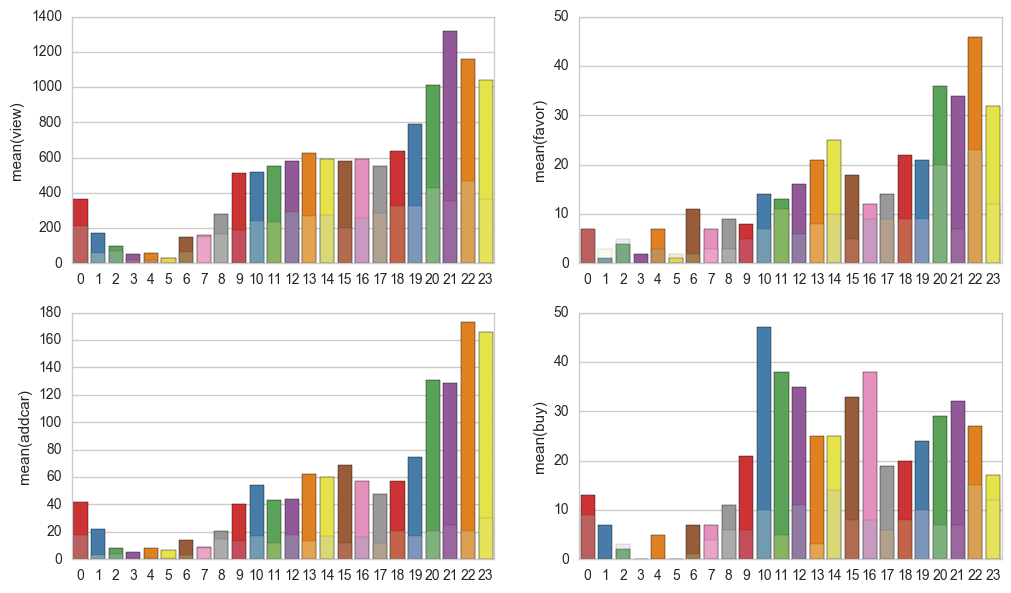

In [6]:
#在小时的维度上进行观察
hour_detail=user_df[['user_id','item_id','hour','view','favor','addcar','buy']][user_df.date<'2014-12-18'].groupby(['user_id','item_id','hour'],as_index=False).sum()
month_detail=user_df[['user_id','item_id','date','view','favor','addcar','buy']].groupby(['user_id','item_id','date'],as_index=False).sum()
day18_positive=month_detail[['user_id','item_id']][(month_detail.date=='2014-12-18')&(month_detail.buy!=0)]
day18_negative=month_detail[['user_id','item_id']][(month_detail.date=='2014-12-18')&(month_detail.buy==0)].sample(n=6124)
day18_buy_hour_detail=day18_positive.merge(hour_detail,how='left',on=['user_id','item_id'],).groupby('hour',as_index=False).sum()
day18_notbuy_hour_detail=day18_negative.merge(hour_detail,how='left',on=['user_id','item_id'],).groupby('hour',as_index=False).sum()

f,axes=plt.subplots(2,2,figsize=(12,7))
sns.barplot(day18_buy_hour_detail.index, day18_buy_hour_detail.view,palette="Set1",ax=axes[0,0])
sns.barplot(day18_notbuy_hour_detail.index, day18_notbuy_hour_detail.view,palette="Set3",ax=axes[0,0],alpha=.3)
sns.barplot(day18_buy_hour_detail.index, day18_buy_hour_detail.favor,palette="Set1",ax=axes[0,1])
sns.barplot(day18_notbuy_hour_detail.index, day18_notbuy_hour_detail.favor,palette="Set3",ax=axes[0,1],alpha=.3)
sns.barplot(day18_buy_hour_detail.index, day18_buy_hour_detail.addcar,palette="Set1",ax=axes[1,0])
sns.barplot(day18_notbuy_hour_detail.index, day18_notbuy_hour_detail.addcar,palette="Set3",ax=axes[1,0],alpha=.3)
sns.barplot(day18_buy_hour_detail.index, day18_buy_hour_detail.buy,palette="Set1",ax=axes[1,1])
sns.barplot(day18_notbuy_hour_detail.index, day18_notbuy_hour_detail.buy,palette="Set3",ax=axes[1,1],alpha=.3)

- 按小时维度来看，总体情况跟我们刚才分析的时间维度上的所有对的总体趋势是一致的，被购买的商品始终被关注的更多一些。
- 另外，最后一幅购买图也比较有意思。刚才分析了，白天的转化率要高一些，而这个统计图也说明，白天的商品被重复购买的更多一些，所以，将小时这个维度划分为几个时间段比较合理，如上午、中午、下午、晚上、凌晨等等。

---------------------------

### 3.用户特征分析

In [7]:
#先采样出在18号买了的与没有买的用户
month_detail=user_df[['user_id','item_id','date','view','favor','addcar','buy']].groupby(['user_id','item_id','date'],as_index=False).sum()
day18_positive=month_detail[['user_id']][(month_detail.date=='2014-12-18')&(month_detail.buy!=0)].drop_duplicates()
day18_negative=month_detail[['user_id']][(month_detail.date=='2014-12-18')&(month_detail.buy==0)].drop_duplicates().sample(n=3053)

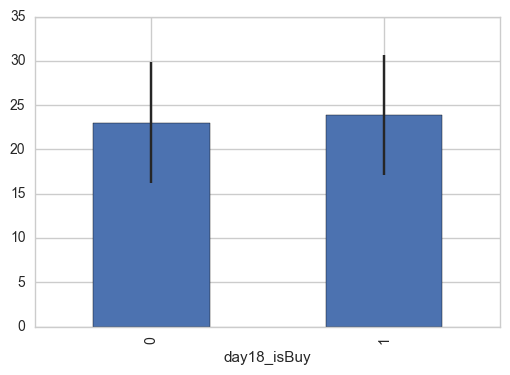

In [8]:
#统计所有用户一个月内活跃的天数
user_active_totaldays=user_df[['user_id','date']].drop_duplicates().groupby('user_id',as_index=False).count()
#统计18号购买及未购买的用户的活跃情况
day18_buy_active_totaldays=day18_positive.merge(user_active_totaldays,how='left',on=['user_id'],)
day18_notbuy_active_totaldays=day18_negative.merge(user_active_totaldays,how='left',on=['user_id'],)

avgerage_active_totaldays = DataFrame([day18_notbuy_active_totaldays.date.mean(),day18_buy_active_totaldays.date.mean()])
std_active_totaldays      = DataFrame([day18_notbuy_active_totaldays.date.std(),day18_buy_active_totaldays.date.std()])

avgerage_active_totaldays.index.names = ["day18_isBuy"]
avgerage_active_totaldays.plot(yerr=std_active_totaldays,kind='bar',legend=False)

- 通过以上可以看出，在18号购买与未购买用户的曾经活跃天数的均值及方差都非常的接近，如果我们把用户某个时间段的活跃天数拿来做特征，就值得商榷了，这根本体现不出是否购买的差别。
- 活跃的天数差不多，那么只会是活跃天数的分布不同了。有可能18号购买了的用户在18号前几天都一直在活跃，未购买的用户只在18号当天或者附近天数活跃了一下，对于这种，目前还并未想到有什么算法能够体现出活跃的分布情况。所以，可以直接使用独热编码，将30天的情况全部给表明出来，某一天活跃了，就被标记为1。用这种方式会出现一个问题，这些日期维度上特征的值非常小，而其他特征的值可能会非常大，这对于模型训练也是不好的。所以，个人认为比较好的方式是，对于独热编码的特征单独提出来进行训练，其他特征进行训练，最后做融合比较好。

--------------

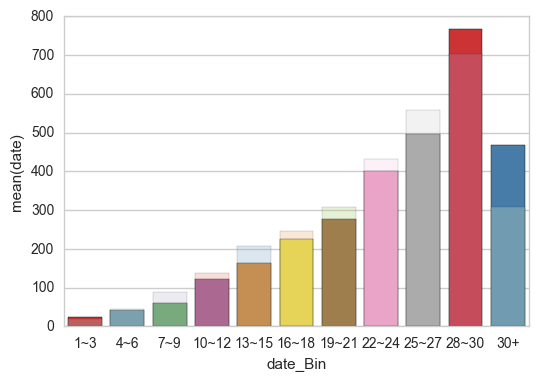

In [9]:
#使用分箱操作，去统计特定活跃天数内的用户数量
def binning(col, cut_points, labels=None):
  minval = col.min()
  maxval = col.max()
  #利用最大值和最小值创建分箱点的列表
  break_points = [minval] + cut_points + [maxval]
  #如果没有标签，则使用默认标签0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)
  #使用pandas的cut功能分箱
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

cut_points = [3,6,9,12,15,18,21,24,27,30]
labels = ["1~3","4~6","7~9","10~12","13~15","16~18","19~21","22~24","25~27","28~30","30+"]

user_active_totaldays=user_df[['user_id','date']].drop_duplicates().groupby('user_id',as_index=False).count()
day18_buy_active_totaldays=day18_positive.merge(user_active_totaldays,how='left',on=['user_id'],)
day18_notbuy_active_totaldays=day18_negative.merge(user_active_totaldays,how='left',on=['user_id'],)

day18_buy_active_totaldays["date_Bin"] = binning(day18_buy_active_totaldays["date"], cut_points, labels)
day18_notbuy_active_totaldays["date_Bin"] = binning(day18_notbuy_active_totaldays["date"], cut_points, labels)

day18_buy_active_totaldays=day18_buy_active_totaldays.groupby('date_Bin',as_index=False).count()
day18_notbuy_active_totaldays=day18_notbuy_active_totaldays.groupby('date_Bin',as_index=False).count()

sns.barplot(day18_buy_active_totaldays.date_Bin, day18_buy_active_totaldays.date,palette="Set1")
sns.barplot(day18_notbuy_active_totaldays.date_Bin, day18_notbuy_active_totaldays.date,palette="Set3",alpha=.3)

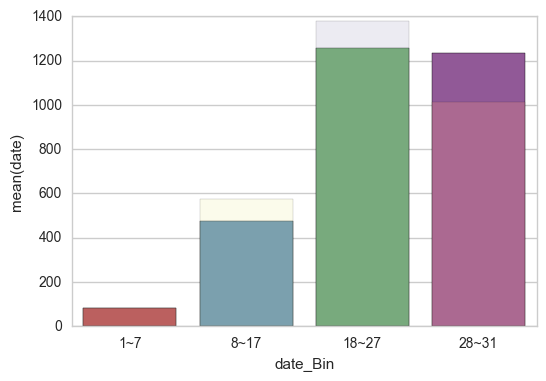

In [10]:
def binning(col, cut_points, labels=None):
  minval = col.min()
  maxval = col.max()
  #利用最大值和最小值创建分箱点的列表
  break_points = [minval] + cut_points + [maxval]
  #如果没有标签，则使用默认标签0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)
  #使用pandas的cut功能分箱
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

cut_points = [7,17,27]
labels = ["1~7","8~17","18~27","28~31"]


user_active_totaldays=user_df[['user_id','date']].drop_duplicates().groupby('user_id',as_index=False).count()
day18_buy_active_totaldays=day18_positive.merge(user_active_totaldays,how='left',on=['user_id'],)
day18_notbuy_active_totaldays=day18_negative.merge(user_active_totaldays,how='left',on=['user_id'],)

day18_buy_active_totaldays["date_Bin"] = binning(day18_buy_active_totaldays["date"], cut_points, labels)
day18_notbuy_active_totaldays["date_Bin"] = binning(day18_notbuy_active_totaldays["date"], cut_points, labels)

day18_buy_active_totaldays=day18_buy_active_totaldays.groupby('date_Bin',as_index=False).count()
day18_notbuy_active_totaldays=day18_notbuy_active_totaldays.groupby('date_Bin',as_index=False).count()

sns.barplot(day18_buy_active_totaldays.date_Bin, day18_buy_active_totaldays.date,palette="Set1")
sns.barplot(day18_notbuy_active_totaldays.date_Bin, day18_notbuy_active_totaldays.date,palette="Set3",alpha=.3)

- 以上给出了两种分箱方式，一种以3天为一个周期，另一种以1周为一个周期。根据统计结果来看，购买与未购买的用户的曾经活跃天数相差不大，未购买的用户活跃天数更少，但少不了多少。
- 这个统计图更进一步证实了，以活跃天数的总数作为特征并不是一个好主意。

-------------------------

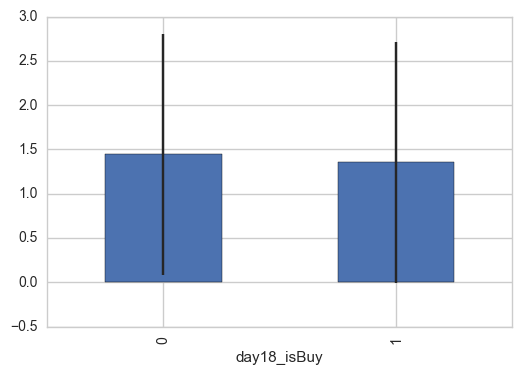

In [11]:
#统计购买日之前的最后活跃日期
later_hot_day=user_df[['user_id','date']][user_df.date<'2014-12-18'].sort_values(['user_id','date'],ascending=False).drop_duplicates('user_id')
buy_day=pd.to_datetime('2014-12-18')
def daydiff(day):
    return (buy_day-day).days
later_hot_day['days_to_buyday']=later_hot_day.date.map(daydiff).astype(int)

day18_buy_rencently_active_day=day18_positive.merge(later_hot_day,how='left',on=['user_id'],)
day18_notbuy_rencently_active_day=day18_negative.merge(later_hot_day,how='left',on=['user_id'])

avgerage_rencently_active_day = DataFrame([day18_notbuy_rencently_active_day.days_to_buyday.mean(),day18_buy_rencently_active_day.days_to_buyday.mean()])
std_rencently_active_day      = DataFrame([day18_notbuy_rencently_active_day.days_to_buyday.std(),day18_buy_rencently_active_day.days_to_buyday.std()])

avgerage_rencently_active_day.index.names = ["day18_isBuy"]
avgerage_rencently_active_day.plot(yerr=std_rencently_active_day,kind='bar',legend=False)


- 统计图里的均值、方差均相差很小，最近活跃日期距离购买日期的天数这个指标恐怕不是一个理想的指标。
- 这正印证了，大多数购买了的与没购买的用户，在18号之前一两天内均活跃过。

---------------------------------------------------------------------------

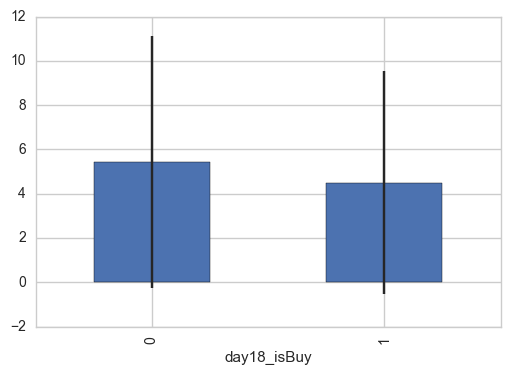

In [12]:
#现在不看最后活跃日期，而去看最后购买日期
later_buy_day=user_df[['user_id','date']][(user_df.date<'2014-12-18')&(user_df.buy>0)].sort_values(['user_id','date'],ascending=False).drop_duplicates('user_id')
buy_day=pd.to_datetime('2014-12-18')
def daydiff(day):
    return (buy_day-day).days
later_buy_day['days_to_buyday']=later_buy_day.date.map(daydiff).astype(int)

day18_buy_rencently_buy_day=day18_positive.merge(later_buy_day,how='left',on=['user_id'])
day18_notbuy_rencently_buy_day=day18_negative.merge(later_buy_day,how='left',on=['user_id'])

avgerage_rencently_buy_day = DataFrame([day18_notbuy_rencently_buy_day.days_to_buyday.mean(),day18_buy_rencently_buy_day.days_to_buyday.mean()])
std_rencently_buy_day      = DataFrame([day18_notbuy_rencently_buy_day.days_to_buyday.std(),day18_buy_rencently_buy_day.days_to_buyday.std()])

avgerage_rencently_buy_day.index.names = ["day18_isBuy"]
avgerage_rencently_buy_day.plot(yerr=std_rencently_buy_day,kind='bar',legend=False)

- 以上可以看出，在18号买了的用户中，会在更短的前几天内有过购买行为，虽然平均数相差在一天内，但是方差达到了2天左右，这个指标波动相对来说比较大，可以作为一个特征使用。

-----------------------------

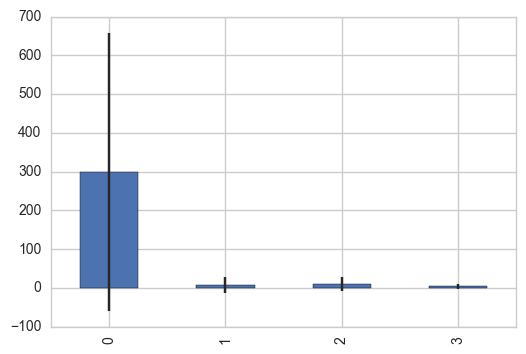

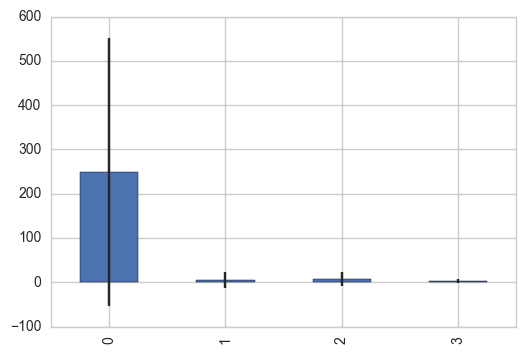

In [13]:
#接着进行更细粒度分析，分别从一周内浏览、收藏、加购以及购买四种行为进行分析
user_detail=user_df[['user_id','view','favor','addcar','buy']][(user_df.date>'2014-12-12')&(user_df.date<'2014-12-18')].groupby('user_id',as_index=False).sum().sort_values(['buy'],ascending=False)

day18buy_3days_user_detail=day18_positive.merge(user_detail,how='left',on=['user_id']).fillna(0)
day18notbuy_3days_user_detail=day18_negative.merge(user_detail,how='left',on=['user_id']).fillna(0)

day18buy_3days_user_detail_average=DataFrame([day18buy_3days_user_detail.view.mean(),day18buy_3days_user_detail.favor.mean(),day18buy_3days_user_detail.addcar.mean(),day18buy_3days_user_detail.buy.mean(),])
day18buy_3days_user_detail_std    =DataFrame([day18buy_3days_user_detail.view.std(),day18buy_3days_user_detail.favor.std(),day18buy_3days_user_detail.addcar.std(),day18buy_3days_user_detail.buy.std(),])

day18buy_3days_user_detail_average.plot(yerr=day18buy_3days_user_detail_std,kind='bar',legend=False)

day18notbuy_3days_user_detail_average=DataFrame([day18notbuy_3days_user_detail.view.mean(),day18notbuy_3days_user_detail.favor.mean(),day18notbuy_3days_user_detail.addcar.mean(),day18notbuy_3days_user_detail.buy.mean(),])
day18notbuy_3days_user_detail_std    =DataFrame([day18notbuy_3days_user_detail.view.std(),day18notbuy_3days_user_detail.favor.std(),day18notbuy_3days_user_detail.addcar.std(),day18notbuy_3days_user_detail.buy.std(),])

day18notbuy_3days_user_detail_average.plot(yerr=day18notbuy_3days_user_detail_std,kind='bar',legend=False)


- 两图辨识度不是很高，但是仔细看可以看出，18号购买了的用户在这一周内，活跃度还是要稍微高于18号当天没购买的那些用户的。

---------------------------

In [14]:
#最后看看转化率上的关系
user_tranpec_detail=user_df[['user_id','view','favor','addcar','buy']][user_df.date<'2014-12-18'].groupby('user_id',as_index=False).sum().sort_values(['buy'],ascending=False)
user_tranpec_detail['tran_view_pec']=user_tranpec_detail['buy']/(user_tranpec_detail['view']+1)
user_tranpec_detail['tran_favor_pec']=user_tranpec_detail['buy']/(user_tranpec_detail['favor']+1)
user_tranpec_detail['tran_addcar_pec']=user_tranpec_detail['buy']/(user_tranpec_detail['addcar']+1)

day18buy_user_tranpec_detail=day18_positive.merge(user_tranpec_detail,how='left',on=['user_id'])
day18notbuy_user_tranpec_detail=day18_negative.merge(user_tranpec_detail,how='left',on=['user_id'])

day18buy_user_tranpec_average=DataFrame([day18buy_user_tranpec_detail['tran_view_pec'].mean(),day18buy_user_tranpec_detail['tran_favor_pec'].mean(),day18buy_user_tranpec_detail['tran_addcar_pec'].mean()])
day18notbuy_user_tranpec_average=DataFrame([day18notbuy_user_tranpec_detail['tran_view_pec'].mean(),day18notbuy_user_tranpec_detail['tran_favor_pec'].mean(),day18notbuy_user_tranpec_detail['tran_addcar_pec'].mean()])

day18buy_user_tranpec_average.columns=['per_buy']
day18notbuy_user_tranpec_average.columns=['per_notbuy']
day18buy_user_tranpec_average.join(day18notbuy_user_tranpec_average)

,per_buy,per_notbuy
0,0.018823,0.014515
1,5.390467,4.140442
2,1.136233,1.006907


- 从以上平均转化率可以看出，18号买了的用户，浏览、收藏、加购的平均转化率均要高于18号没买的，这是去除了18号当天的数据所得出的数据，可以看出，相当一部分人是属于经常使用淘宝的用户。

--------------------------------------